# Data routine

Load, transform, categorizem compare and visualize geochemical datasets

## Preambule

In [1]:
# Reset & import

%reset -f

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
from matplotlib.colors import TwoSlopeNorm

from datetime import datetime

from utils.display_frozen_df import display_frozen_df
from utils import safe_save
from utils.functions import calc_all
from utils.tools import reorder_columns, merge_catalogue, prioritize_rows, plot_labels, plot_columns
import utils.constants as cst

figure_path = '/Users/romaintilhac/Documents/Research/localities/Kohistan/figures/'
error_suffix = '_err'


## Load data

### Main data file

In [ ]:
# Load

file_path = '/Users/romaintilhac/Documents/Research/localities/Kohistan/data/Lu-Hf/Lu-Hf_Jijal.csv'
df_main = pd.read_csv(file_path)
print("Loaded data file: ", file_path)

df_main = df_main.sort_values(by=['Zone', 'Lithology', 'Sample'])

# List samples
assert 'Sample' in df_main.columns
sample_list = df_main["Sample"].unique().tolist()

Loaded data file:  /Users/romaintilhac/Documents/Research/localities/Kohistan/data/Lu-Hf/Lu-Hf_Jijal.csv


In [3]:
# # Model export

# def groupZone_Unit(row):
#     if row in ['GGZ', 'GGZ lenses']:
#         return 'Mafic'
#     else:
#         return 'Ultramafic'
    
# df_main['Unit'] = df_main['Zone'].apply(groupZone_Unit)
# df_ultramafics = df_main[df_main['Unit'] == 'Ultramafic']
# df_ultramafics.to_pickle('df_ultramafics.pkl')


### Additional data

In [4]:
# Dhuime et al. (2007) appendix Table 2 (isotopes)
file_path = '/Users/romaintilhac/Documents/Research/localities/Kohistan/data/Dhuime-et-al.-2007_Table2.xls'
df_Dhuime2007_iso = pd.read_excel(file_path)
print("Loaded : ", file_path)

# Remove empty columns
df_Dhuime2007_iso = df_Dhuime2007_iso.dropna(axis=1, how='all')

# Keep WR only and prioritize non-unleached
df_Dhuime2007_iso = df_Dhuime2007_iso[df_Dhuime2007_iso['Material'] == 'WR']
df_Dhuime2007_iso = prioritize_rows(
    df_Dhuime2007_iso,
    group_cols=['Sample', 'Material'],
    priority_col='Comment',
    preferred_values=['', 'Unleached']
)

# Check sample_list
missing_samples = [s for s in sample_list if s not in df_Dhuime2007_iso['Sample'].values]
assert not missing_samples, f"Additional data not found for: {missing_samples}"
df_Dhuime2007_iso = df_Dhuime2007_iso[df_Dhuime2007_iso['Sample'].isin(sample_list)].copy()

Loaded :  /Users/romaintilhac/Documents/Research/localities/Kohistan/data/Dhuime-et-al.-2007_Table2.xls


In [5]:
# Ewing & Muntener (2018) Table 2

data = {
    "Sample": ["K704", "K723", "KK-10", "K728", "K742a"],
    "Lithology": ["Garnet gabbro", "Garnet gabbro", "Grt-rich Grt gabbro", "Paragonite gabbro", "Epidote pegmatite"],
    "Latitude": [35.08, 35.07, 35.08, 35.08, 35.11],
    "Longitude": ["72.96594 °E", "72.96342 °E", "72.9633 °E", "72.96341 °E", "72.98838 °E"],
    "Altitude": [971, 893, None, 890, 1100], #[m]
    "Distance": [1600, 800, 1300, 1400, 2800], #[m]
    "Hf": [14, 13, 15, 13, 17], #Av. Hf in Rt (ppm)
    "176Hf/177Hf": [0.28305, 0.28329, 0.28326, 0.28310, 0.28317], #Wtd. Av. 176Hf/177Hf
    "176Hf/177Hf_err": [0.00009, 0.00016, 0.00011, 0.00007, 0.00013], #±(95% conf.) Hf_ratio
    "εHf(i)": [11.4, 20.1, 18.9, 13.3, 15.9], #Wtd. Av. εHf(i)
    "εHf(i)_err": [3.2, 5.7, 3.9, 2.6, 4.7], #±(95% conf.) εHf(i)
    "MSWD": [0.8, 2.3, 0.6, 2.2, 2.1],
    "n": ["13/13", "9/10", "9/10", "15/15", "10/10"]
}

df_EwingMuntener2018 = pd.DataFrame(data)
df_EwingMuntener2018=calc_all(df_EwingMuntener2018)


### Catalogue

In [6]:
# Dhuime et al. (2007) appendix Table 1 (WR)
folder_path = '/Users/romaintilhac/Documents/Research/localities/Kohistan/data/' 
file_name = 'Dhuime-et-al.-2007_Table1.xls'

file_path = folder_path + file_name
df_catalogue = pd.read_excel(file_path)
print("Loaded : ", file_path)

# Remove empty columns
df_catalogue = df_catalogue.dropna(axis=1, how='all')

# Check catalogue
missing_samples= set(df_main['Sample']) - set(df_catalogue['Sample'])
assert not missing_samples, f"Missing samples in catalogue: {missing_samples}"

Loaded :  /Users/romaintilhac/Documents/Research/localities/Kohistan/data/Dhuime-et-al.-2007_Table1.xls


### Build master

In [7]:
# Merge catalogue and data
df = merge_catalogue(df_catalogue, df_main) # catalogue_columns_to_add=['Unit', 'Lithology'],

df = merge_catalogue(
    df,
    df_Dhuime2007_iso,
    data_columns_to_add=['87Sr/86Sr'],
    suffix = "_Dhuime2007" # in case of duplicates
)

df = calc_all(df, 100, 0.05)

df = reorder_columns(df)
display_frozen_df(df)


Sample,Lithology,Lithology_meta,Lithology_conflict,Unit,Zone,Distance,Lat(N),Long(E),dup#,run#,SiO2,TiO2,Al2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,LOI,Total,Mg#,Mg#_calc,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Lu_meta,Lu_conflict,Ba,Cr,Cs,Hf,Hf_meta,Hf_conflict,Nb,Ni,Pb,Rb,Sc,Sr,Ta,Th,Ti,U,V,Y,Zr,87Sr/86Sr,147Sm/144Nd,147Sm/144Nd_err,143Nd/144Nd,143Nd/144Nd_err,143Nd/144Nd(i),143Nd/144Nd(i)_err,143Nd/144Nd(i)_calc,143Nd/144Nd(i)_err_calc,εNd,εNd_err,εNd_calc,εNd_err_calc,εNd(i),εNd(i)_err,εNd(i)_calc,εNd(i)_err_calc,176Lu/177Hf,176Lu/177Hf_err,176Hf/177Hf,176Hf/177Hf_err,176Hf/177Hf(i),176Hf/177Hf(i)_err,176Hf/177Hf(i)_calc,176Hf/177Hf(i)_err_calc,εHf,εHf_err,εHf_calc,εHf_err_calc,εHf(i),εHf(i)_err,εHf(i)_calc,εHf(i)_err_calc,ΔεHf,ΔεHf_err,ΔεHf_calc,ΔεHf_err_calc,ΔεHf(i),ΔεHf(i)_err,ΔεHf(i)_calc,ΔεHf(i)_err_calc,Material,SREE,(Sr/Nd)PM,(Ba/La)PM,(Pb/Ce)PM,(Th/La)PM,Eu*,Pb*,LaN/YbN,LaN/SmN,GdN/YbN,Gd/Lu,Hf/Nd,La/Sm,Lu/Hf,Nb/Ta,Sm/Nd,Zr/Hf,Gd/Lu_calc,Hf/Nd_calc,La/Sm_calc,Lu/Hf_calc,Nb/Ta_calc,Sm/Nd_calc,Zr/Hf_calc,1/Hf,1/Hf_calc
KH04-06,"(Grt, ±Cpx, ±Pl)-hornblendites","(Grt, ±Cpx, ±Pl)-hornblendite",True,UM-GHZ,GHZ/GGZ,-210,35°04'17.84'',72°57'45.00'',2,1,40.710000,1.260,17.360000,10.293550,0.0800,12.930000,11.370000,2.290,0.1500,0.010,1.58,98.033550,69.056804,69.127835,0.216449,0.994720,0.239200,1.861566,0.802030,0.436615,1.104168,0.168878,1.088451,0.202415,0.494591,0.064794,0.364321,0.047431,0.054822,True,16.699966,238.400,0.099052,0.167166,0.179190,True,0.195979,152.400,0.278390,0.745680,NaN,156.529996,0.027006,0.001985,NaN,0.000776,528.600,4.307325,2.250098,0.703664,0.260039,0.013002,0.512987,0.000006,0.512817,0.000011,0.512817,0.000011,6.968808,0.125041,6.968808,0.125041,3.650726,0.207801,3.650726,0.207801,0.040470,0.002023,0.283163,0.000014,0.283088,0.000014,0.283088,0.000014,13.376700,0.484467,13.376700,0.484467,10.705189,0.502657,10.705189,0.502657,1.481397,0.512755,1.481397,0.512755,3.266733,0.574953,3.266733,0.574953,WR,8.093018,5.395793,7.584070,6.996689,0.074137,1.420070,5.913600,0.426159,0.174224,2.501112,23.279377,0.089799,0.269876,0.283736,7.256825,0.430836,13.460229,23.279377,0.089799,0.269876,0.283736,7.256825,0.430836,13.460229,5.982063,5.982063
KH04-06,"(Grt, ±Cpx, ±Pl)-hornblendites","(Grt, ±Cpx, ±Pl)-hornblendite",True,UM-GHZ,GHZ/GGZ,-210,35°04'17.84'',72°57'45.00'',1,1,40.710000,1.260,17.360000,10.293550,0.0800,12.930000,11.370000,2.290,0.1500,0.010,1.58,98.033550,69.056804,69.127835,0.216449,0.994720,0.239200,1.861566,0.802030,0.436615,1.104168,0.168878,1.088451,0.202415,0.494591,0.064794,0.364321,0.048376,0.054822,True,16.699966,238.400,0.099052,0.175501,0.179190,True,0.195979,152.400,0.278390,0.745680,NaN,156.529996,0.027006,0.001985,NaN,0.000776,528.600,4.307325,2.250098,0.703664,0.260039,0.013002,0.512987,0.000006,0.512817,0.000011,0.512817,0.000011,6.968808,0.125041,6.968808,0.125041,3.650726,0.207801,3.650726,0.207801,0.039316,0.001966,0.283192,0.000013,0.283119,0.000013,0.283119,0.000013,14.401966,0.456177,14.401966,0.456177,11.806612,0.474382,11.806612,0.474382,2.506663,0.486114,2.506663,0.486114,4.368156,0.550404,4.368156,0.550404,WR,8.093018,5.395793,7.584070,6.996689,0.074137,1.420070,5.913600,0.426159,0.174224,2.501112,22.824549,0.094276,0.269876,0.275646,7.256825,0.430836,12.820967,22.824549,0.094276,0.269876,0.275646,7.256825,0.430836,12.820967,5.697959,5.697959
KH04-07,"(Hbl, ±Cpx)-garnetites","(Hbl, ±Cpx)-garnetite",True,UM-GHZ,GHZ/GGZ,-210,35°04'17.84'',72°57'45.00'',1,1,41.480000,0.410,17.830000,15.085221,0.4000,10.330000,12.690000,0.120,NaN,0.020,0.00,98.365221,54.886364,54.968713,0.150869,0.686250,0.172260,1.433997,0.937110,0.646625,2.257392,0.501472,4.336409,1.058248,3.195255,0.492851,3.207854,0.562978,0.542200,True,0.820206,54.790,0.051998,0.197677,0.231824,True,0.016838,26.400,0.103310,0.059454,NaN,15.643996,0.021515,0.001675,NaN,0.001508,363.400,23.469338,3.950098,0.703753,0.394437,0.019722,0.513078,0.000008,0.512820,0.000015,0.512820,0.000015,8.743909,0.156838,8.743909,0.156838,3.710

### Database

In [8]:
# Tilhac et al. 2022 Hf-Nd database
file_path = '/Users/romaintilhac/Documents/Research/resources/database/Hf-Nd-isotopes/Hf-Nd_database.csv'
df_HfNd_database = pd.read_csv(file_path)
file_path = '/Users/romaintilhac/Documents/Research/resources/database/Hf-Nd-isotopes/Hf-Nd_catalogue.csv'
df_HfNd_catalogue = pd.read_csv(file_path)

df_HfNd_database = merge_catalogue(df_HfNd_catalogue, df_HfNd_database, key='Locality', catalogue_columns_to_add=['Geodynamic context'])

# categorize
def groupContext_Environment(row):
    if row in ['Mid-ocean ridge', 'Intraoceanic']:
        return 'Oceanic'
    elif row in ['Passive margin', 'Marginal basin', 'Continental margin', 'Accretionary prism']:
        return 'Marginal'
    elif row in ['Back-arc basin', 'Backarc/continental', 'Magmatic arc', 'Continental arc', 'Forearc']:
        return 'Arc-related'
    elif row in ['Intracontinental', 'Orogenic', 'Craton margin', 'Intracratonic', 
                 'Intracratonic rift', 'Continental rift', 'Microcontinental', 'Post-orogenic']:
        return 'Continental'
    else:
        return ''
    
df_HfNd_database['Environment'] = df_HfNd_database['Geodynamic context'].apply(groupContext_Environment)
df_HfNd_database = calc_all(df_HfNd_database)
df_HfNd_database = reorder_columns(df_HfNd_database)

#display(df_Stracke2012.head())

In [ ]:
# Stracke MORB-OIB database
file_path = '/Users/romaintilhac/Documents/Research/resources/database/MORB-OIB_Stracke2012.csv'
df_Stracke2012 = pd.read_csv(file_path)
print("Loaded : ", file_path)

df_Stracke2012 = calc_all(df_Stracke2012)

Loaded :  /Users/romaintilhac/Documents/Research/resources/database/MORB-OIB_Stracke2012.csv


## Filter & categorize

In [10]:
# Do not plot duplicates ()
df = df[(df['dup#'] == 1) & (df['run#'] == 1)]

## Select only specific lithologies
#df = df[df['Lithology'].isin(['(Grt, ±Cpx, ±Pl)-hornblendites', '(Hbl, ±Cpx)-garnetites'])]

In [11]:
def groupZone_Unit(row):
    if row in ['GGZ', 'GGZ lenses']:
        return 'Mafic'
    else:
        return 'Ultramafic'

def renameZone(row):
    if row in ['GHZ/GGZ', 'GHZ/PYZ']:
        return 'GHZ'
    else:
        return row

def group_PEZPYZ(row):
    if row in ['PEZ', 'PYZ']:
        return 'PEZ-PYZ'
    else:
        return row

def refineZone(row):
    if row['Zone'] in ['GGZ']:
        if row['Lithology'] in ['(Grt, ±Cpx, ±Pl)-hornblendites', '(Hbl, ±Cpx)-garnetites', 'Grt-rich (±Hbl, ±Pl)-pyroxenites']:
            return 'GGZ lenses'
        elif row['Lithology'] in ['Garnet Granulites', 'Hbl-Gabbronorites (composite)']:
            return 'GGZ'
    return row['Zone']

df['Unit'] = df['Zone'].apply(groupZone_Unit)
df['Zone'] = df['Zone'].apply(renameZone)
df['Zone'] = df.apply(refineZone, axis=1)
#df_main['Zone'] = df_main['Zone'].apply(group_PEZPYZ)

## Evaluation

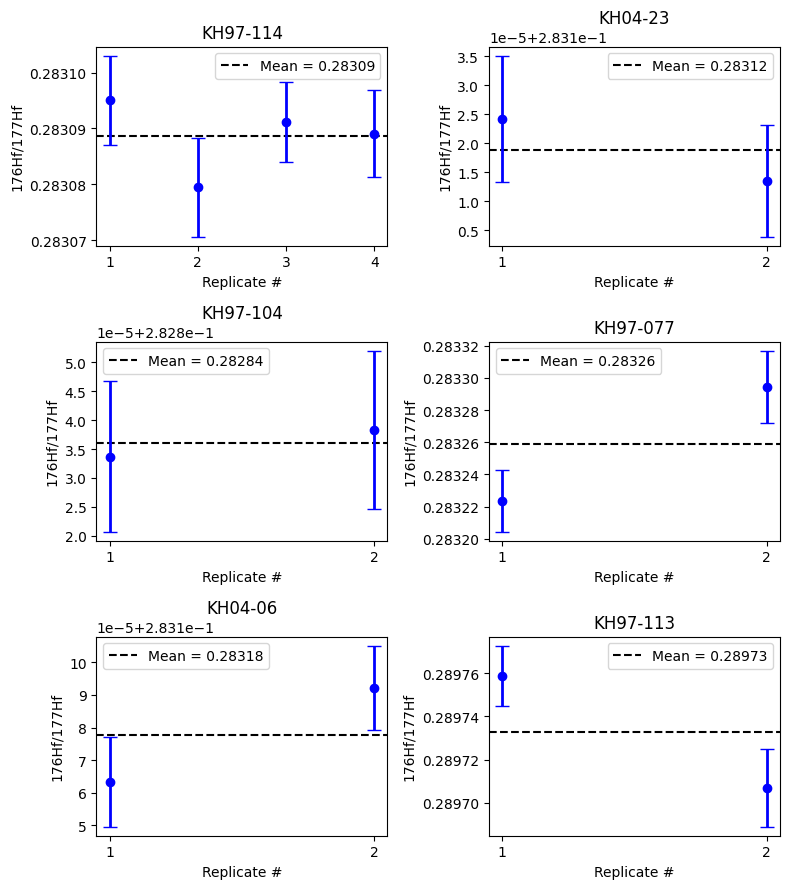

In [12]:
x_column = 'Sample'
y_column = '176Hf/177Hf'
y_error = y_column + error_suffix

# Filter samples with more than one measurement
sample_counts = df_main[x_column].value_counts()
reproducible_samples = sample_counts[sample_counts > 1].index

n_samples = len(reproducible_samples)
n_cols = 2
n_rows = int(np.ceil(n_samples / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3 * n_rows), squeeze=False)

for i, sample in enumerate(reproducible_samples):
    row, col = divmod(i, n_cols)
    ax = axes[row][col]

    df_repro = df_main[df_main[x_column] == sample]
    n_replicates = len(df_repro)
    x_pos = range(n_replicates)
    mean_value = df_repro[y_column].mean()

    ax.axhline(y=mean_value, color='k', linestyle='--', label=f'Mean = {mean_value:.5f}')
    ax.errorbar(
        x_pos,
        df_repro[y_column].values,
        yerr=df_repro[y_error].values,
        fmt='o',
        color='b',
        capsize=5,
        elinewidth=2,
        linestyle='None'
    )

    ax.set_xticks(x_pos)
    ax.set_xticklabels(range(1, n_replicates + 1))  # <-- Replicates from 1 to n
    ax.set_xlabel("Replicate #")
    ax.set_ylabel(y_column)
    ax.set_title(f"{sample}")
    ax.legend()

# Remove unused subplots if any
for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    fig.delaxes(axes[row][col])

fig.tight_layout()
plt.show()


## Global styling

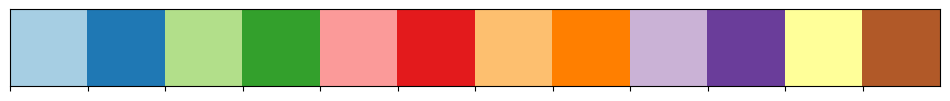

In [13]:
# Change the font family and size globally

mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 15            # Main/default font size (tick labels, legend, etc.)
mpl.rcParams['axes.titlesize'] = 15       # Title font size
mpl.rcParams['axes.labelsize'] = 15       # X/Y axis label font size
mpl.rcParams['xtick.labelsize'] = 15      # X-axis tick labels font size
mpl.rcParams['ytick.labelsize'] = 15      # Y-axis tick labels font size
mpl.rcParams['legend.fontsize'] = 15      # Legend font size

edgecolor = "black" # Border color for the markers
linewidth = 0.5  # Border thickness for the markers
marker_size = 150  # Size of the markers

# List of distinct marker styles

marker_styles = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', '<', '>', 'H', 'd', '+', 'x']
palette = sns.color_palette("Paired")
sns.palplot(palette)


## Covariation plots

### Plot by

In [14]:
# Plot/color by
style_column = 'Lithology'
hue_column = 'Unit'

# Create the marker_map
marker_map = {}
print("marker_map = {")
for i, cat in enumerate(df[style_column].unique()):
    marker = marker_styles[i % len(marker_styles)]
    marker_map[cat] = marker
    print(f"    '{cat}': '{marker}',")
print("}")

# Create the color_map
color_map = {}
print("color_map = {")
for i, cat in enumerate(df[hue_column].unique()):
    color_map[cat] = palette[i]
    print(f"    '{cat}': palette[{i}],")
print("}")

# Extract the order of categories
hue_order = list(color_map.keys())
style_order = list(marker_map.keys())


marker_map = {
    '(Grt, ±Cpx, ±Pl)-hornblendites': 'o',
    '(Hbl, ±Cpx)-garnetites': 's',
    'Garnet Granulites': '^',
    'Websterites & Clinopyroxenites': 'v',
    'Grt-poor pyroxenites': 'D',
    'Grt-rich (±Hbl, ±Pl)-pyroxenites': 'P',
    'Lherzolite lens': '*',
    'Hbl-Gabbronorites (composite)': 'X',
}
color_map = {
    'Ultramafic': palette[0],
    'Mafic': palette[1],
}


In [15]:
# Edit/sort marker/color maps

marker_map = {
    'Websterites & Clinopyroxenites': 's',
    'Lherzolite lens': '*',
    'Grt-poor pyroxenites': 'd',
    'Grt-rich (±Hbl, ±Pl)-pyroxenites': 'D',
    '(Grt, ±Cpx, ±Pl)-hornblendites': 'p',
    '(Hbl, ±Cpx)-garnetites': 'H',
    'Garnet Granulites': '^',
    'Hbl-Gabbronorites (composite)': 'o'
}

if hue_column == 'Zone':
    color_map = {
        'PEZ': palette[7],
        'PYZ': palette[2],
        'GHZ': palette[11],
        'GGZ lenses': palette[3],
        'GGZ': palette[4],
    }
    color_map = {
        'PEZ-PYZ': palette[7],
        'GHZ': palette[11],
        'GGZ': palette[4],
    }
elif hue_column == 'Unit':
    color_map = {
        'Ultramafic': '#3BAFDA', 
        'Mafic': '#C05FBF', 
    }

# Extract the order of categories
hue_order = list(color_map.keys())
style_order = list(marker_map.keys())

### Isochron & mixing

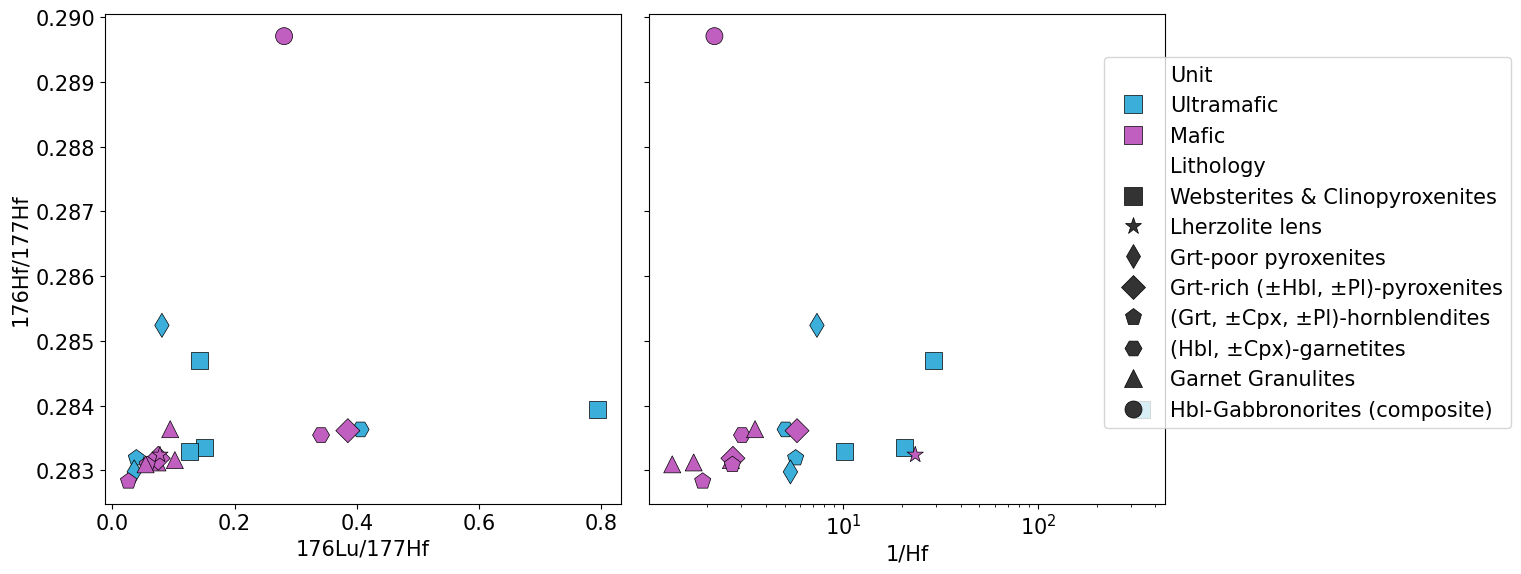

In [16]:
# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # 1 row, 2 columns

# --------- PLOT 0 ---------
plot = 0
x_column = '176Lu/177Hf'
y_column = '176Hf/177Hf'
x_error = x_column + error_suffix
y_error = y_column + error_suffix
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plot], zorder = 2)
## Plot with optional error bars
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)

# --------- PLOT 1 --------- 
axe_number = 1
x_column = '1/Hf' 
y_column = '176Hf/177Hf'
x_error = x_column + error_suffix
y_error = y_column + error_suffix
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[axe_number], zorder = 2)
## Plot with optional error bars
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[axe_number].set_xscale('log')

# Adjust axis limits
#xmin = 0
#xmax = 50
#ymin = 0.282
#ymax = 0.286
#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)

# Remove individual legends and add single shared legend at figure level
handles, labels = axes[axe_number].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(1.1, 0.9))
axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout()
plt.show()

### Distance

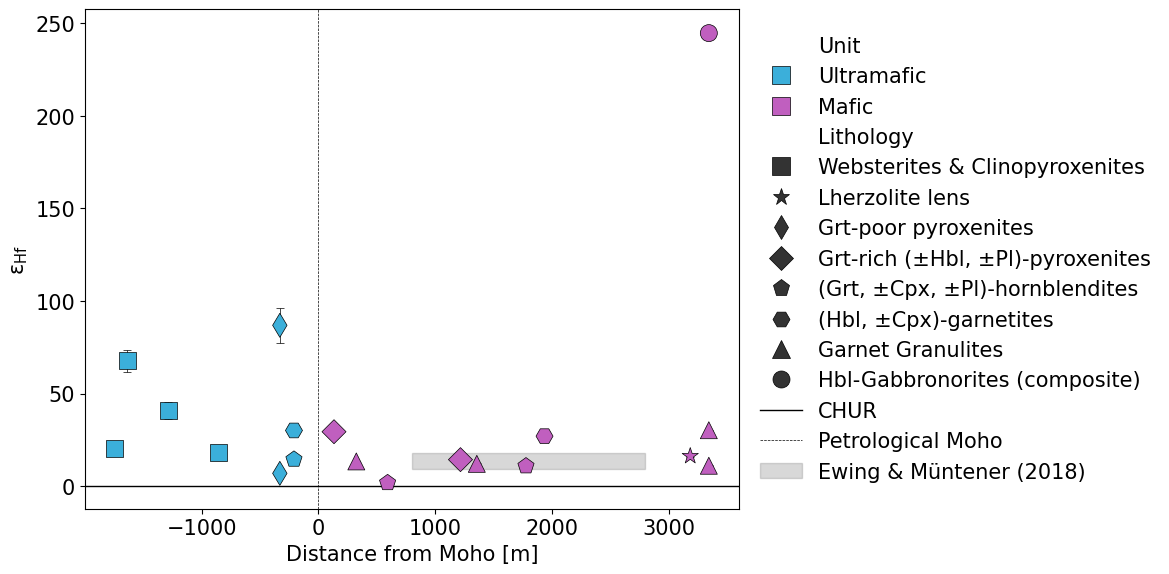

In [17]:
# Single plot vs Distance

x_column = 'Distance'
y_column = 'εHf'

fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot with seaborn on ax
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order,
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,
                ax=ax, zorder=2)

## Plot with optional error bars
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)

# Lines
ax.axhline(0, color="black", linestyle="-", linewidth=1, zorder=1,  label="CHUR")
ax.axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological Moho") # Moho

# Additional data
xmin = df_EwingMuntener2018[x_column].min()
xmax = df_EwingMuntener2018[x_column].max()
ymin = df_EwingMuntener2018[y_column].min()
ymax = df_EwingMuntener2018[y_column].max()
xlims = ax.get_xlim()
xmin_frac = (xmin - xlims[0]) / (xlims[1] - xlims[0])
xmax_frac = (xmax - xlims[0]) / (xlims[1] - xlims[0])
ax.axhspan(ymin, ymax, xmin=xmin_frac, xmax=xmax_frac, color='grey', alpha=0.3, label='Ewing & Müntener (2018)')

# sns.scatterplot(data=df_EwingMuntener2018, x=x_column, y=y_column, s=50, markers='o', color='grey',edgecolor='black',ax=ax, label='Ewing & Müntener (2018)')
# ## Plot with optional error bars
# x_error_column = x_column + error_suffix
# y_error_column = y_column + error_suffix
# xerr = df_EwingMuntener2018[x_error_column] if x_error_column in df_EwingMuntener2018.columns else None
# yerr = df_EwingMuntener2018[y_error_column] if y_error_column in df_EwingMuntener2018.columns else None
# ax.errorbar(
#     df_EwingMuntener2018[x_column], df_EwingMuntener2018[y_column],
#     xerr=xerr, yerr=yerr,
#     zorder=0, fmt='none', ecolor='k',
#     alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
# )

# Axis labels with upright epsilon for ΔεHf if needed
ax.set_xlabel(plot_labels(x_column))
ax.set_ylabel(plot_labels(y_column))

# Legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0, frameon=False)

plt.tight_layout()

savefile_name = figure_path + 'deltaEHf_vs_distance_byUnit.pdf'
plt.savefig(savefile_name, bbox_inches='tight', dpi=300)

plt.show()

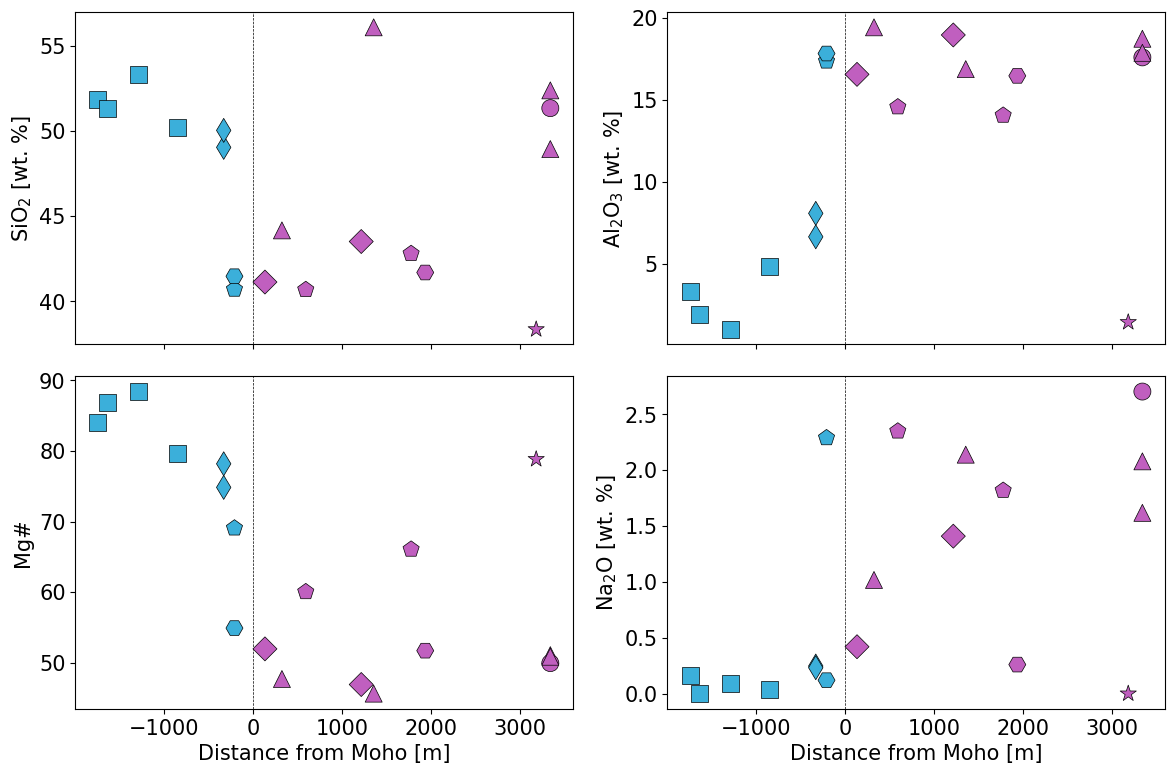

In [18]:
# Major-element plots vs distance
# figure dimensions
width_in = 12
height_in = 8

x_column = 'Distance'
x_error_column = x_column + error_suffix

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(2, 2, figsize=(width_in, height_in), sharex=True)  # 1 row, 2 columns

# --------- PLOT 0 --------- 
plotx=0; ploty=0;
y_column = 'SiO2'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 1 --------- 
plotx=0; ploty=1;
y_column = 'Al2O3'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 2 --------- 
plotx=1; ploty=0;
y_column = 'Mg#'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 3 --------- 
plotx=1; ploty=1;
y_column = 'Na2O'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# Moho
axes[0, 0].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[0, 1].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[1, 0].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[1, 1].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")

# Remove individual legends and add single shared legend at figure level
handles, labels = axes[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(1.2, 0.9))
axes[0, 0].legend_.remove()
axes[0, 1].legend_.remove()
axes[1, 0].legend_.remove()
axes[1, 1].legend_.remove()

file_name = figure_path + 'ME_vs_distance.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi=300)
    
plt.tight_layout()
plt.show()

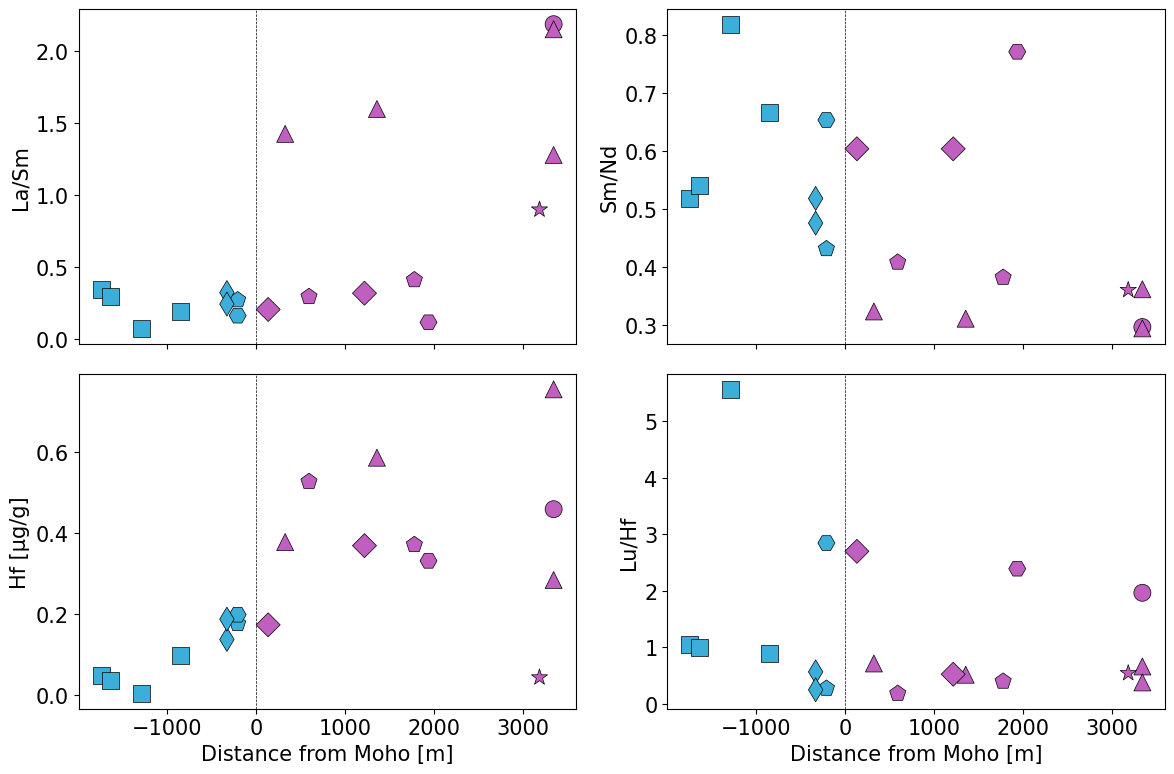

In [19]:
# Trace-element plots vs distance 

# figure dimensions
width_in = 12
height_in = 8

x_column = 'Distance'
x_error_column = x_column + error_suffix

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(2, 2, figsize=(width_in, height_in), sharex=True)  # 1 row, 2 columns

# --------- PLOT 0 --------- 
plotx=0; ploty=0;
y_column = 'La/Sm'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 1 --------- 
plotx=0; ploty=1;
y_column = 'Sm/Nd'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 2 --------- 
plotx=1; ploty=0;
y_column = 'Hf'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 3 --------- 
plotx=1; ploty=1;
y_column = 'Lu/Hf'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# Moho
axes[0, 0].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[0, 1].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[1, 0].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[1, 1].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")

# Remove individual legends and add single shared legend at figure level
handles, labels = axes[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(1.2, 0.9))
axes[0, 0].legend_.remove()
axes[0, 1].legend_.remove()
axes[1, 0].legend_.remove()
axes[1, 1].legend_.remove()

savefile_name = figure_path + 'TE_vs_distance.pdf'
plt.savefig(savefile_name, bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

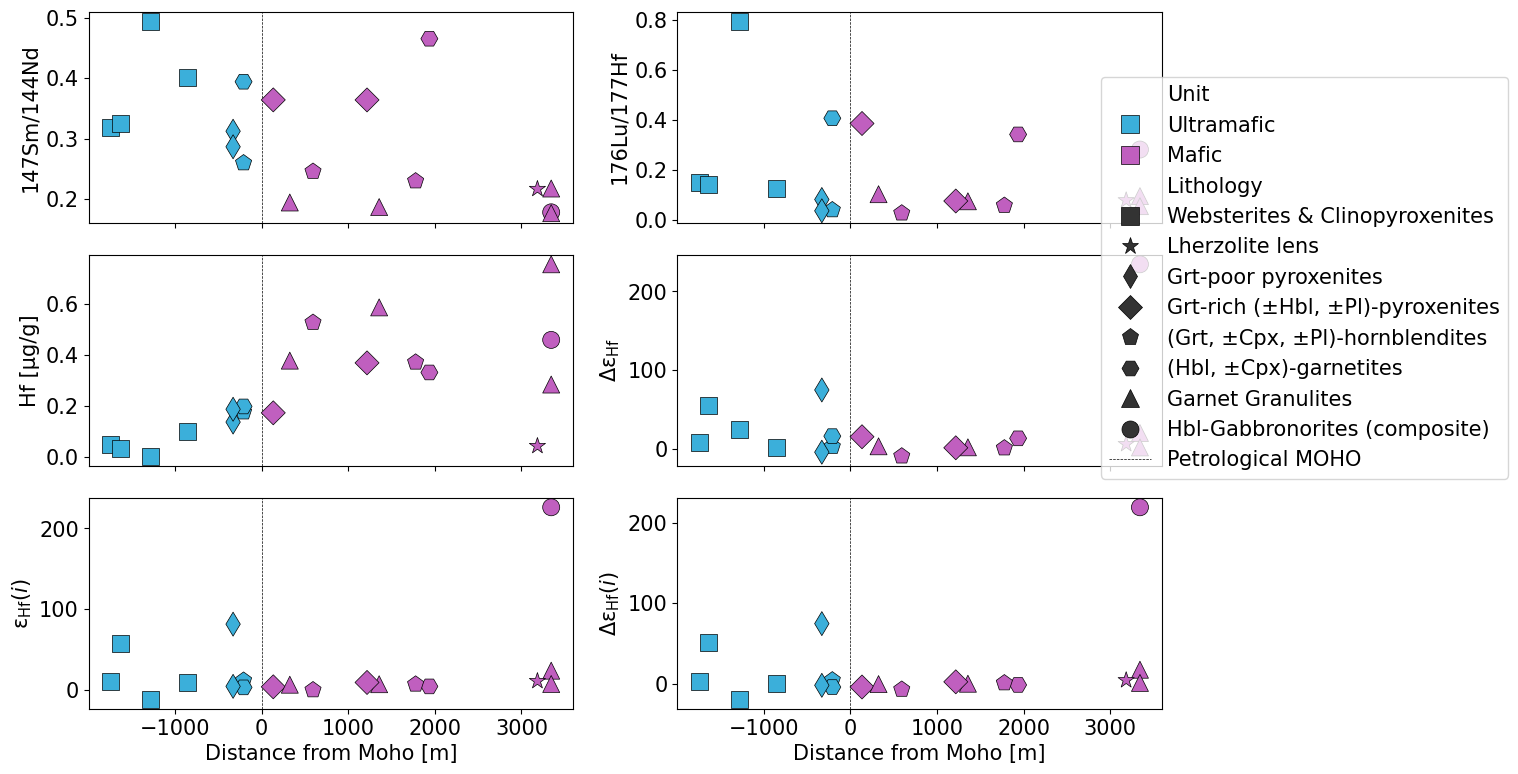

In [20]:
# Multiple plots vs Distance

# figure dimensions
width_in = 12
height_in = 8

x_column = 'Distance'
x_error = x_column + error_suffix

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(3, 2, figsize=(width_in, height_in), sharex=True)  # 1 row, 2 columns

# --------- PLOT 0 --------- 
plotx=0; ploty=0;
y_column = '147Sm/144Nd'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 1 --------- 
plotx=0; ploty=1;
y_column = '176Lu/177Hf'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 2 --------- 
plotx=1; ploty=0;
y_column = 'Hf'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 3 --------- 
plotx=1; ploty=1;
y_column = 'ΔεHf'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 4 --------- 
plotx=2; ploty=0;
y_column = 'εHf(i)'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# --------- PLOT 5 --------- 
plotx=2; ploty=1;
y_column = 'ΔεHf(i)'
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[plotx, ploty], zorder=2)
## Plot with optional error bars
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)
axes[plotx, ploty].set_xlabel(plot_labels(x_column))
axes[plotx, ploty].set_ylabel(plot_labels(y_column))

# Moho
axes[0, 0].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[0, 1].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[1, 0].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[1, 1].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[2, 0].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")
axes[2, 1].axvline(0, color="black", linestyle="--", linewidth=0.5, zorder=1, label="Petrological MOHO")

# Remove individual legends and add single shared legend at figure level
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(1.1, 0.9))
axes[0, 0].legend_.remove()
axes[0, 1].legend_.remove()
axes[1, 0].legend_.remove()
axes[1, 1].legend_.remove()
axes[2, 0].legend_.remove()
axes[2, 1].legend_.remove()
    
plt.tight_layout()
plt.show()

### εHf-εNd

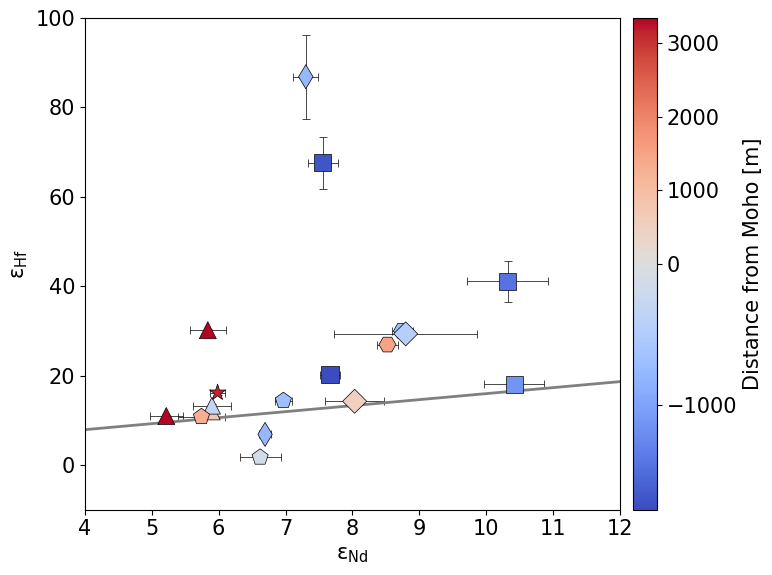

In [21]:
# Color-coded EHf vs ENd plots

fig, ax = plt.subplots(figsize=(8, 6))

x_column = 'εNd'
y_column = 'εHf'

# Error bars
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix
ax.errorbar(df[x_column], df[y_column],
            xerr=df[x_error_column], yerr=df[y_error_column],
            fmt='none', ecolor='k', alpha=1, capsize=3, capthick=0.5, elinewidth=0.5, zorder=0)

# Normalization: center colormap at zero
vmin = df['Distance'].min()
vmax = df['Distance'].max()
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Scatter plot: color by Distance, diverging colormap
sc = sns.scatterplot(data=df, x=x_column, y=y_column, hue='Distance', style=style_column,
                     palette='coolwarm',  # or 'RdBu_r'
                     markers=marker_map, style_order=style_order,
                     s=marker_size, edgecolor=edgecolor, linewidth=linewidth,
                     ax=ax, zorder=4, legend=False)  # Hide automatic legend for hue

# Apply custom colors to points
points = ax.collections[-1]
points.set_norm(norm)
points.set_cmap('coolwarm')

# Mantle array line
x_values = np.linspace(-50, +50, 100)
y_values = cst.HfNd_array_a * x_values + cst.HfNd_array_b
ax.plot(x_values, y_values, color="grey", linewidth=2, zorder=1)

# # Additional data
# sns.scatterplot(data=df_Stracke2012, x=x_column, y=y_column, hue="Type",
#                 s=10, marker='o', ax=ax, zorder=3)

# Adjust axis limits
xmin = 4
xmax = 12
ymin = -10
ymax = 100
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.xlabel(plot_labels(x_column))
plt.ylabel(plot_labels(y_column))

# Legend (without Distance)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0, frameon=False)

# Add colorbar for Distance
sm = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, location='right', pad=0.02)
cbar.set_label("Distance from Moho [m]")

plt.tight_layout()

savefile_name = figure_path + 'EHf_vs_ENd_colorcoded.pdf'
plt.savefig(savefile_name, bbox_inches='tight', dpi=300)

plt.show()


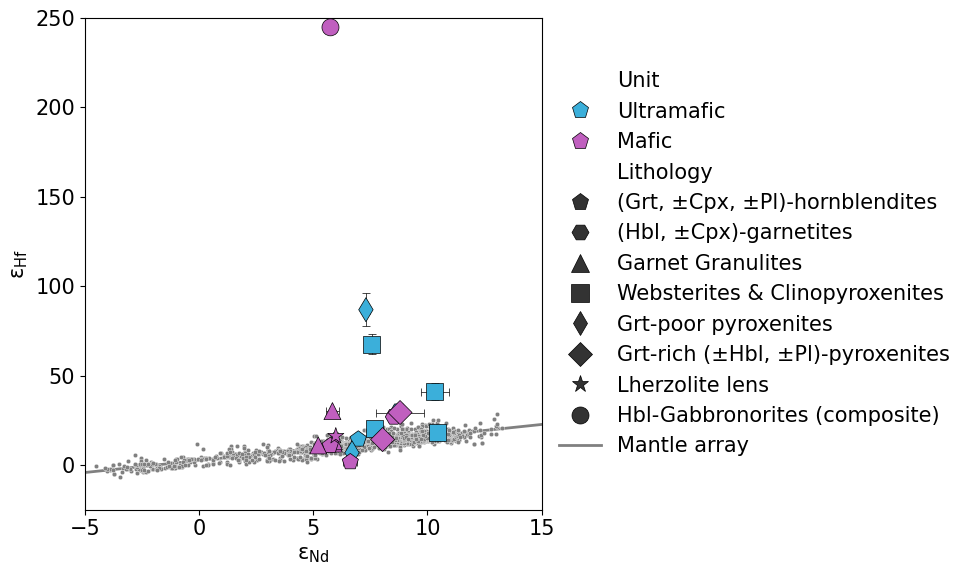

In [22]:
# EHf vs ENd (single plot)

fig, ax = plt.subplots(figsize=(10, 6))

x_column = 'εNd'
y_column = 'εHf'

# Error bars
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix
ax.errorbar(df[x_column], df[y_column],
            xerr=df[x_error_column], yerr=df[y_error_column],
            fmt='none', ecolor='k', alpha=1, capsize=3, capthick=0.5, elinewidth=0.5, zorder = 0)

# Scatter plot with seaborn
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order,
                markers=marker_map, #style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,
                ax=ax, zorder=4)

# Mantle array line
x_values = np.linspace(-50, +50, 100)
y_values = cst.HfNd_array_a * x_values + cst.HfNd_array_b
ax.plot(x_values, y_values, color="grey", linewidth=2, label="Mantle array", zorder=1)

# Additional data
sns.scatterplot(data=df_Stracke2012, x=x_column, y=y_column, color='grey', #hue='grey',
                s=10, marker='o', ax=ax, zorder=3)

# Axis limits
xmin, xmax = -5, 15
ymin, ymax = -25, 250
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.xlabel(plot_labels(x_column))
plt.ylabel(plot_labels(y_column))

# Legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0, frameon=False)

plt.tight_layout()

savefile_name = figure_path + 'EHf_vs_ENd_byUnit.pdf'
plt.savefig(savefile_name, bbox_inches='tight', dpi=300)

plt.show()

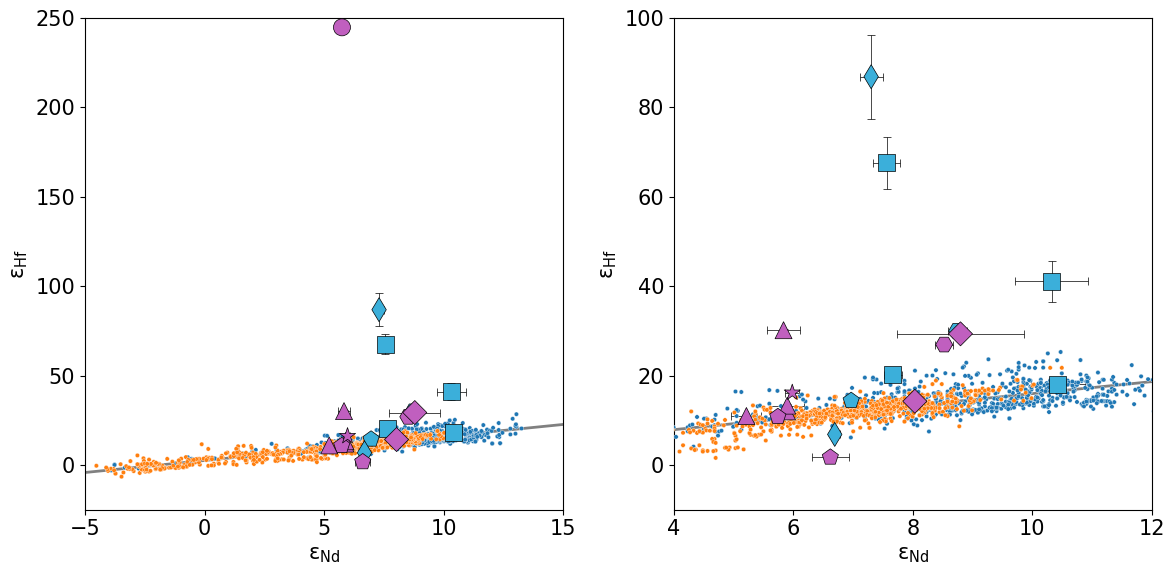

In [24]:
# EHf vs ENd (multiple plots)

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6));  # 2 rows, 1 column

# Mantle array
x_values = np.linspace(-50, +50, 100)
y_values = cst.HfNd_array_a * x_values + cst.HfNd_array_b


# --------- PLOT 0 --------- 
axe_number = 0
x_column = 'εNd'
y_column = 'εHf'
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix

axes[axe_number].errorbar(df[x_column], df[y_column], xerr=df[x_error_column], yerr=df[y_error_column], fmt='none', ecolor='k', alpha=1, capsize=3, capthick=0.5, elinewidth=0.5)
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[axe_number], zorder=4,
               )

# Plot additional data
axes[axe_number].plot(x_values, y_values, color="grey", linewidth=2, label="Mantle array", zorder=1)
# sns.scatterplot(data=Tilhac_et_al_2022, x=x_column, y=y_column, color="grey", s=10, markers='o', zorder=2)
sns.scatterplot(data=df_Stracke2012, x=x_column, y=y_column, hue="Type", s=10, markers='o', ax=axes[axe_number], zorder=3)

# Adjust axis limits
xmin = -5
xmax = 15
ymin = -25
ymax = 250
axes[axe_number].set_xlim(xmin, xmax)
axes[axe_number].set_ylim(ymin, ymax)

axes[axe_number].set_xlabel(plot_labels(x_column))
axes[axe_number].set_ylabel(plot_labels(y_column))

# --------- PLOT 1 --------- 
axe_number = 1
x_column_i = 'εNd'
y_column_i = 'εHf'
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix

axes[axe_number].errorbar(df[x_column_i], df[y_column_i], xerr=df[x_error_column], yerr=df[y_error_column], fmt='none', ecolor='k', alpha=1, capsize=3, capthick=0.5, elinewidth=0.5)
sns.scatterplot(data=df, x=x_column_i, y=y_column_i, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order, 
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,                
                ax=axes[axe_number], zorder=4,
               )

# Plot additional data
axes[axe_number].plot(x_values, y_values, color="grey", linewidth=2, label="Mantle array", zorder=1)
# sns.scatterplot(data=df_Tilhac2022, x=x_column, y=y_column, color="grey", s=10, markers='o', zorder=2)
sns.scatterplot(data=df_Stracke2012, x=x_column, y=y_column, hue="Type", s=10, markers='o', ax=axes[1], zorder=3)
#axes[axe_number].axhspan(10, 20, color='lightgreen', alpha=0.3, label='Ewing & Müntener (2018) ', zorder=0)

# Adjust axis limits
xmin = 4
xmax = 12
ymin = -10
ymax = 100
axes[axe_number].set_xlim(xmin, xmax)
axes[axe_number].set_ylim(ymin, ymax)

axes[axe_number].set_xlabel(plot_labels(x_column))
axes[axe_number].set_ylabel(plot_labels(y_column))

# Remove individual legends and add single shared legend at figure level
#handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.4, 1))
axes[0].legend_.remove()
axes[1].legend_.remove()

savefile_name = figure_path + 'EHf_vs_ENd_zoom.pdf'
plt.savefig(savefile_name, bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()


### x-y plot

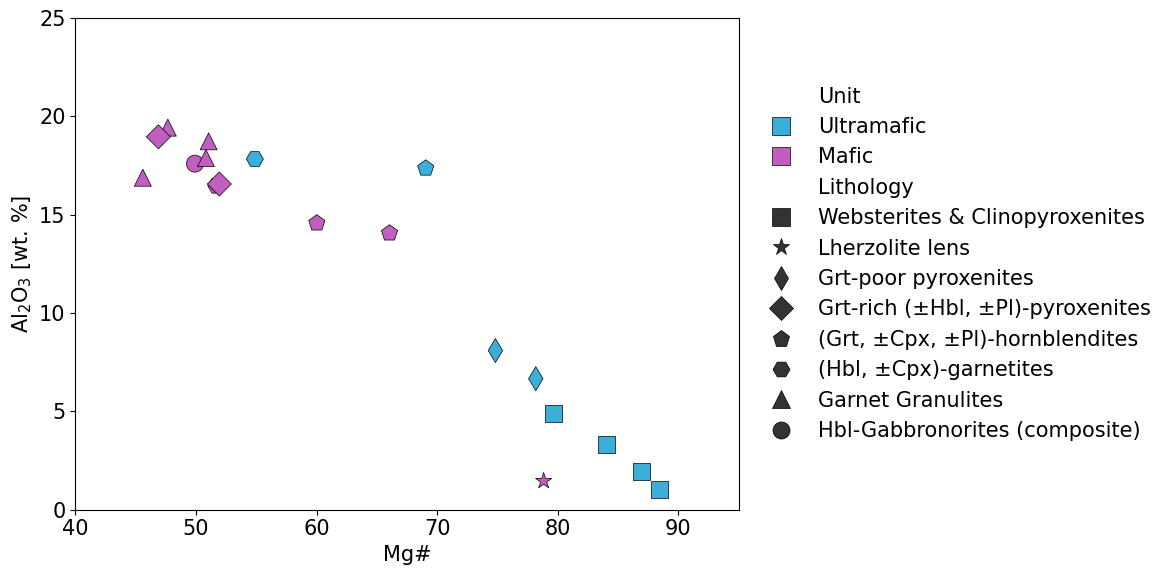

In [25]:
# x-y plot

x_column = 'Mg#'
y_column = 'Al2O3'

fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot with seaborn on ax
sns.scatterplot(data=df, x=x_column, y=y_column, hue=hue_column, style=style_column,
                palette=color_map, hue_order=hue_order,
                markers=marker_map, style_order=style_order,
                s=marker_size, edgecolor=edgecolor, linewidth=linewidth,
                ax=ax, zorder=2)

## Plot with optional error bars
x_error_column = x_column + error_suffix
y_error_column = y_column + error_suffix
xerr = df[x_error_column] if x_error_column in df.columns else None
yerr = df[y_error_column] if y_error_column in df.columns else None
ax.errorbar(
    df[x_column], df[y_column],
    xerr=xerr, yerr=yerr,
    zorder=0, fmt='none', ecolor='k',
    alpha=1, capsize=3, capthick=0.5, elinewidth=0.5
)

plt.xlim(40, 95)
plt.ylim(0, 25)

# Axis labels with upright epsilon for ΔεHf if needed
ax.set_xlabel(plot_labels(x_column))
ax.set_ylabel(plot_labels(y_column))

# Legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0, frameon=False)

plt.tight_layout()

plt.show()

## Custom/quick plot

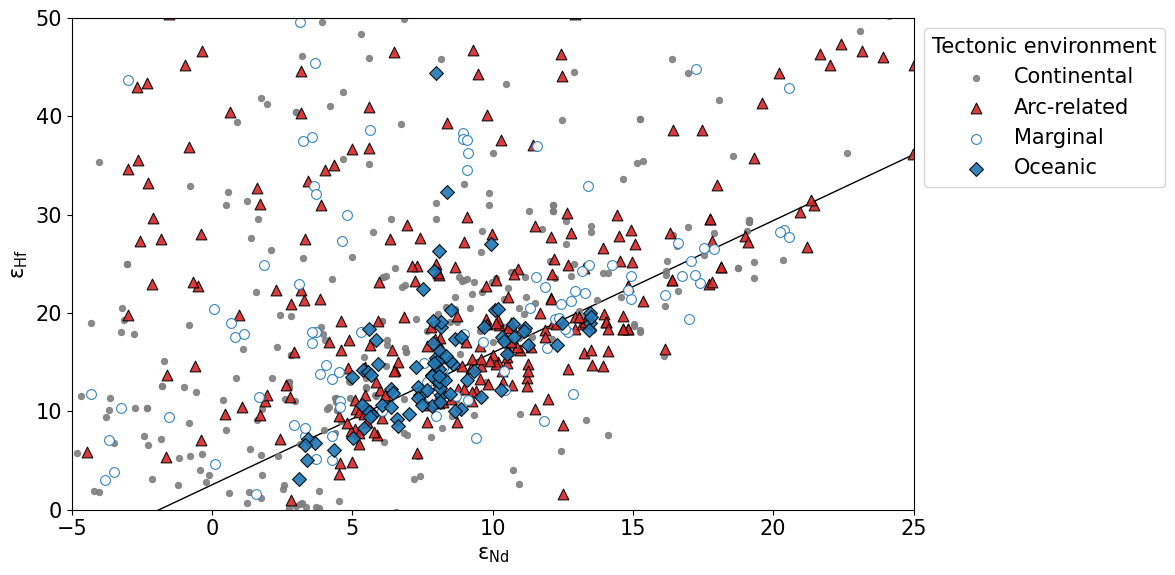

In [26]:
df_plot = df_HfNd_database
x_column = 'εNd'
y_column = 'εHf'
hue_column_custom = 'Environment'

# Custom style based on image
style_map = {
    'Continental': {
        'marker': 'o', 'facecolor': '#7F7F7F', 'edgecolor': None, 'size': 20
    },
    'Arc-related': {
        'marker': '^', 'facecolor': '#D62728', 'edgecolor': 'black', 'size': 60
    },
    'Marginal': {
        'marker': 'o', 'facecolor': 'white', 'edgecolor': '#1F77B4', 'size': 50
    },
    'Oceanic': {
        'marker': 'D', 'facecolor': '#1F77B4', 'edgecolor': 'black', 'size': 50
    }
}

# Prepare figure
plt.figure(figsize=(12, 6))

# Loop through environments and plot individually
for env, props in style_map.items():
    subset = df_plot[df_plot[hue_column_custom] == env]
    plt.scatter(
        subset[x_column],
        subset[y_column],
        s=props['size'],
        c=props['facecolor'],
        edgecolors=props['edgecolor'],
        marker=props['marker'],
        linewidth=0.8,
        alpha=0.9,
        label=env,
        zorder=2
    )

# Mantle array line
x_values = np.linspace(-50, +50, 100)
y_values = cst.HfNd_array_a * x_values + cst.HfNd_array_b
plt.plot(x_values, y_values, color="black", linewidth=1, zorder=1)

# Mean
df_global_arcs = df_HfNd_database[df_HfNd_database['Environment'] == 'Arc-related']

# Axis labels
plt.xlabel(plot_labels(x_column))
plt.ylabel(plot_labels(y_column))

# Optional axis limits (uncomment if needed)
plt.xlim(-5, 25)
plt.ylim(0, 50)

# Legend
plt.legend(title='Tectonic environment', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

savefile_name = figure_path + 'EHf_vs_ENd_database.pdf'
plt.savefig(savefile_name, bbox_inches='tight', dpi=300)

plt.show()


## Statistics

### Statistics styling

In [27]:
# Sort by

category_column = 'Unit'

# Generate and print default color map
color_map_stats = {category: palette[i] for i, category in enumerate(df[category_column].unique())}

hue_order_stats = list(color_map_stats.keys())
print('Default color map:')
print(color_map, '\n')

# Print a reusable code for editing the color map
print('Copy-paste the following to edit the color map:')
print("color_map_stats = {")
for i, cat in enumerate(df[category_column].unique()):
    print(f"    '{cat}': palette[{i}],")
print('} \n')

# List unique subcategories for a given category
def get_unique_subcategories(df, category_value):
    unique_subcategories = df[df[category_column] == category_value][subcategory_column].unique()
    return '\n'.join(unique_subcategories)

subcategory_column = 'Lithology'
category_name = 'mafic'
unique_subcategories = get_unique_subcategories(df, category_name)
print("List of unique", subcategory_column, "for", category_name, ':')
print(unique_subcategories)

common_boxplot_kwargs = dict(
    boxprops=dict(edgecolor='black', linewidth=0.5),
    whiskerprops=dict(color='black', linewidth=0.5),
    capprops=dict(color='black', linewidth=0.5),
    medianprops=dict(color='black', linewidth=0.5),
    flierprops=dict(marker='o', markerfacecolor='black', markersize=3, linestyle='none', linewidth=0.5)
)

Default color map:
{'Ultramafic': '#3BAFDA', 'Mafic': '#C05FBF'} 

Copy-paste the following to edit the color map:
color_map_stats = {
    'Ultramafic': palette[0],
    'Mafic': palette[1],
} 

List of unique Lithology for mafic :



In [28]:
## Edit/sort color map
color_map_stats = {
    'mafic': palette[2],
    'ultramafic': palette[4],
} 

color_map_stats = {
        'Mafic': '#C05FBF', 
        'Ultramafic': '#3BAFDA', 
    }

# Extract the order of categories
hue_order_stats = list(color_map_stats.keys())


### Plots

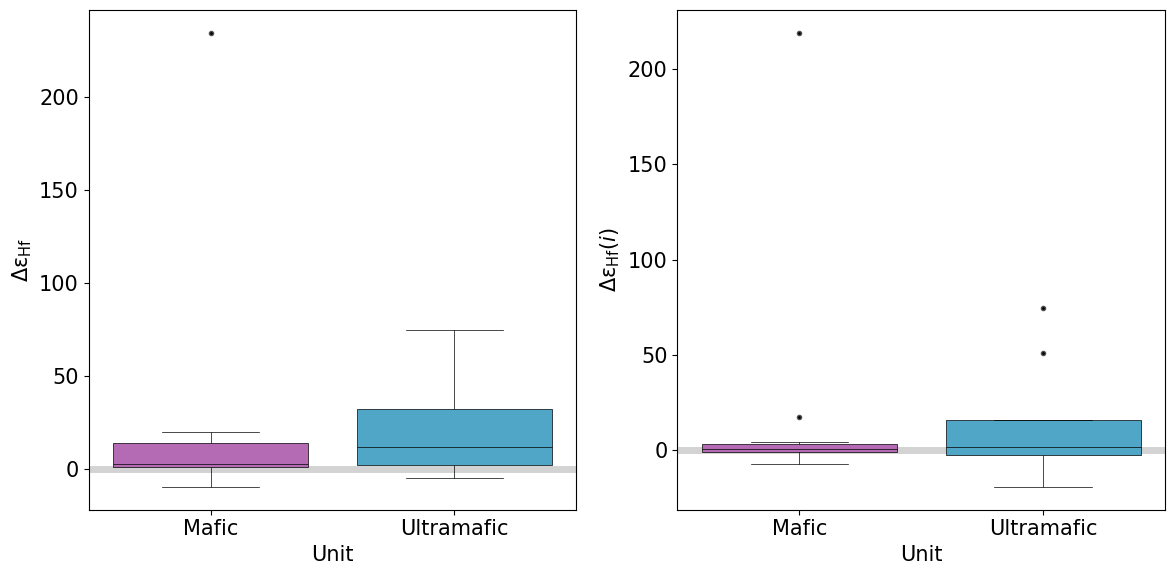

In [29]:
# Box plots

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

value_column = 'ΔεHf'
sns.boxplot(data=df,
            x=category_column,
            y=value_column,
            hue=category_column,
            palette=color_map_stats,
            order=hue_order_stats,
            **common_boxplot_kwargs,
            ax=axes[0])

axes[0].axhline(0, color="lightgrey", linestyle="-", linewidth=5, zorder=1)

axes[0].set_xlabel(plot_labels(category_column))
axes[0].set_ylabel(plot_labels(value_column))

value_column = 'ΔεHf(i)'
sns.boxplot(data=df,
            x=category_column,
            y=value_column,
            hue=category_column,
            palette=color_map_stats,
            order=hue_order_stats,
            **common_boxplot_kwargs,
            ax=axes[1])

axes[1].axhline(0, color="lightgrey", linestyle="-", linewidth=5, zorder=1)

axes[1].set_xlabel(plot_labels(category_column))
axes[1].set_ylabel(plot_labels(value_column))

savefile_name = figure_path + 'decoupling_stats.pdf'
plt.savefig(savefile_name, bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [30]:
# Categorized statistics

value_column = 'ΔεHf'

# Function to compute all boxplot stats, including min and max
def compute_full_stats(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return pd.Series({
        'count': group.count(),
        'mean': group.mean(),
        'std': group.std(),
        'median': group.median(),
        'min': group.min(),
        'max': group.max(),
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr,
        'Whisker_Lower': group[group >= lower].min(),
        'Whisker_Upper': group[group <= upper].max(),
        'Outliers': [group[(group < lower) | (group > upper)].tolist()]
    })

# Compute stats
summary_long = df.groupby(category_column)[value_column].apply(compute_full_stats).unstack().T

# Optional: rename index for clarity
summary_long.index.name = value_column

# Display result
display(summary_long)

Unit,Mafic,Ultramafic
ΔεHf,,
count,11,8
mean,25.949795,22.060893
std,69.651932,28.317765
median,2.829478,11.549011
min,-9.704481,-4.677766
max,234.51606,74.517394
Q1,1.17876,2.250214
Q3,13.976862,32.227062
IQR,12.798102,29.976848
